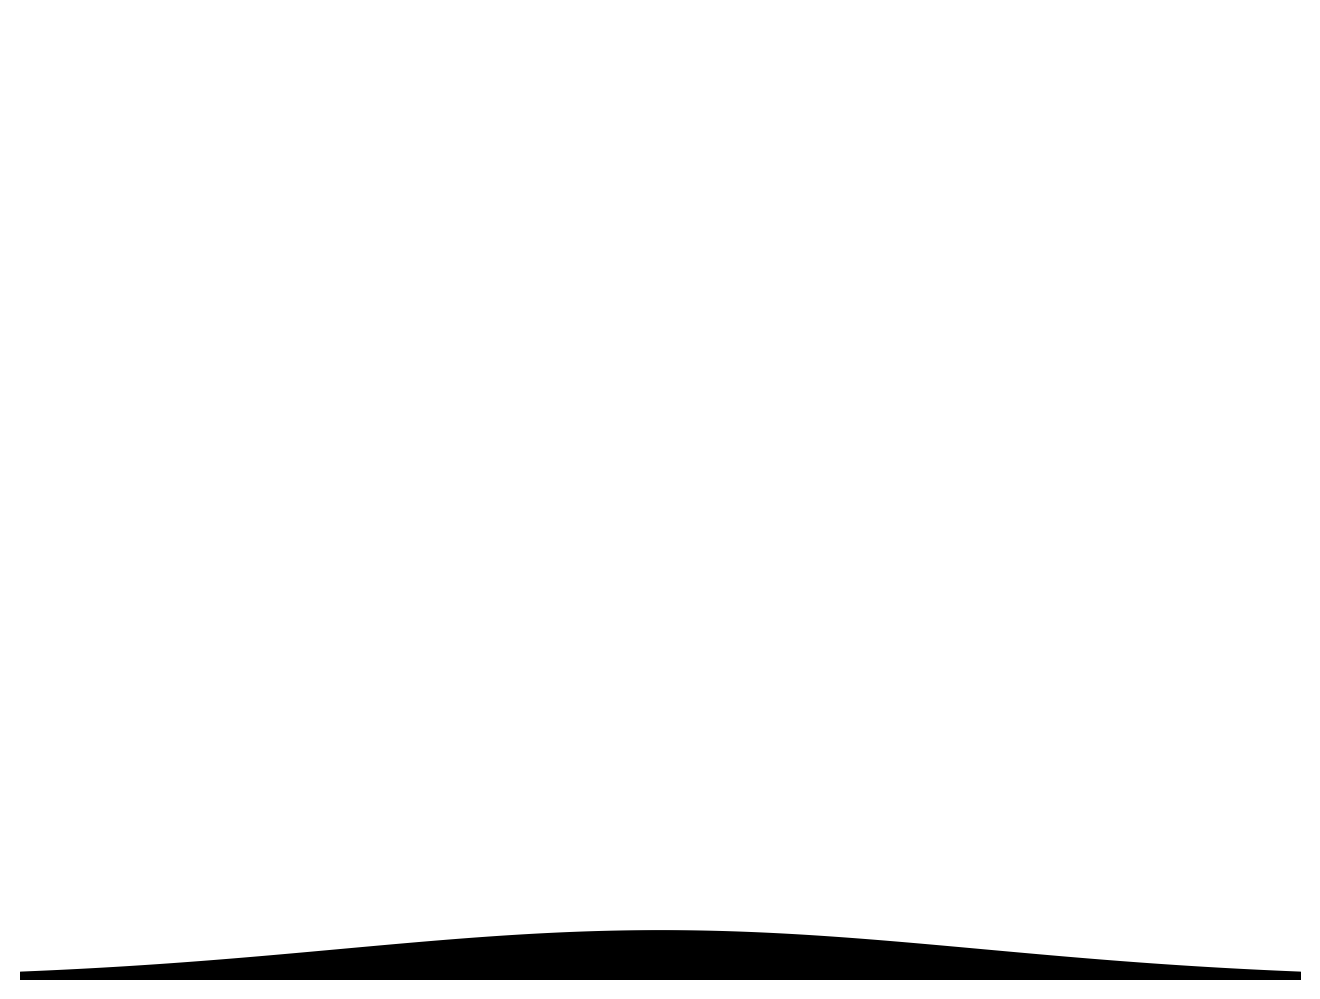

In [101]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-2, 2, 400)


def mountain_shape(x):
    return 0.05 * np.exp(-0.5*((x)/1)**2) 

height = mountain_shape(x)


plt.figure()
plt.fill_between(x, height, color='black')
plt.xlim(-2, 2)
plt.ylim(0.0, 1)
plt.axis('off')  
#remove white space at the edge of the figure
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)


plt.savefig('mountain.jpg', format='jpg', dpi=300)  


plt.show()


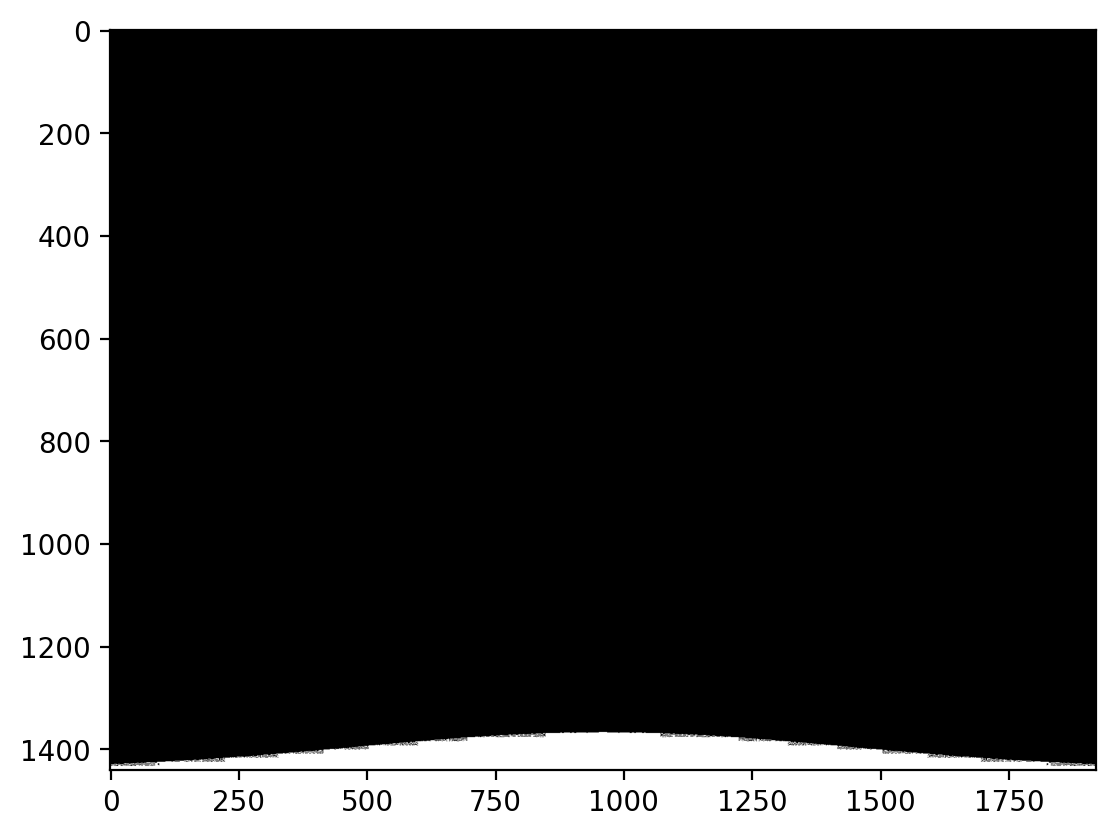

In [102]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
from matplotlib import image
import matplotlib.pyplot as plt
import scipy.interpolate as sci

im = image.imread('mountain.jpg')
im=np.array(im)

for i in range(1440):
    for j in range(1920):
        if im[i][j][0] == 0:
            im[i][j]=[255, 255, 255]
        else:
            im[i][j]=[0, 0, 0]
            
plt.imshow(im)

plt.savefig('mountain.jpg', format='jpg', dpi=300)  # 指定分辨率为300 DPI

In [106]:
cell = np.asarray(im)[:,:,2]

y = 1-np.arange(0,1,1/cell.shape[0])
print(cell.shape)
print(y)
x = np.arange(0,4,4/cell.shape[1])
print(x)

(1440, 1920)
[1.00000000e+00 9.99305556e-01 9.98611111e-01 ... 2.08333333e-03
 1.38888889e-03 6.94444444e-04]
[0.00000000e+00 2.08333333e-03 4.16666667e-03 ... 3.99375000e+00
 3.99583333e+00 3.99791667e+00]


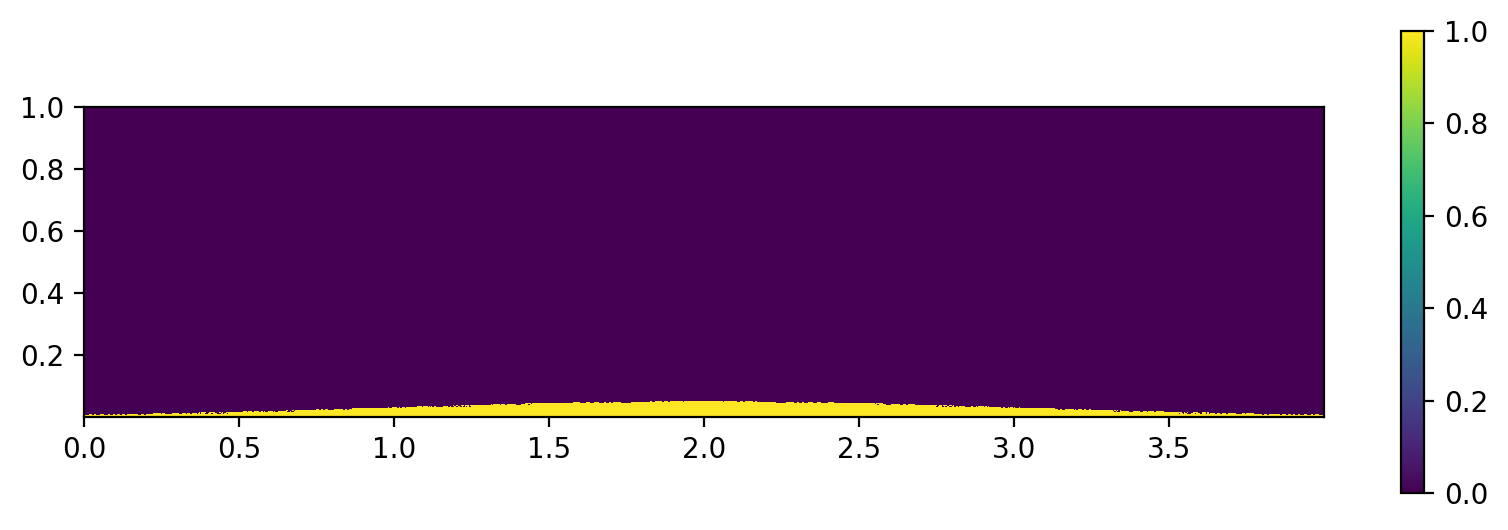

In [107]:
fig, ax = plt.subplots(figsize=[10,3])
mesh = ax.pcolormesh(x, y, cell, shading='auto', vmin=0, vmax=1)
ax.set_aspect(1)
plt.colorbar(mesh)

In [108]:
interp = sci.interp2d(x,y,cell)
#interp = sci.RegularGridInterpolator((x,y), cell.T, method='nearest')

/state/partition1/job-48682867/ipykernel_1006746/3081111272.py:1: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interp = sci.interp2d(x,y,cell)


(1920,) (1440,)


/state/partition1/job-48682867/ipykernel_1006746/765410798.py:8: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  Z = interp(x2, y2)


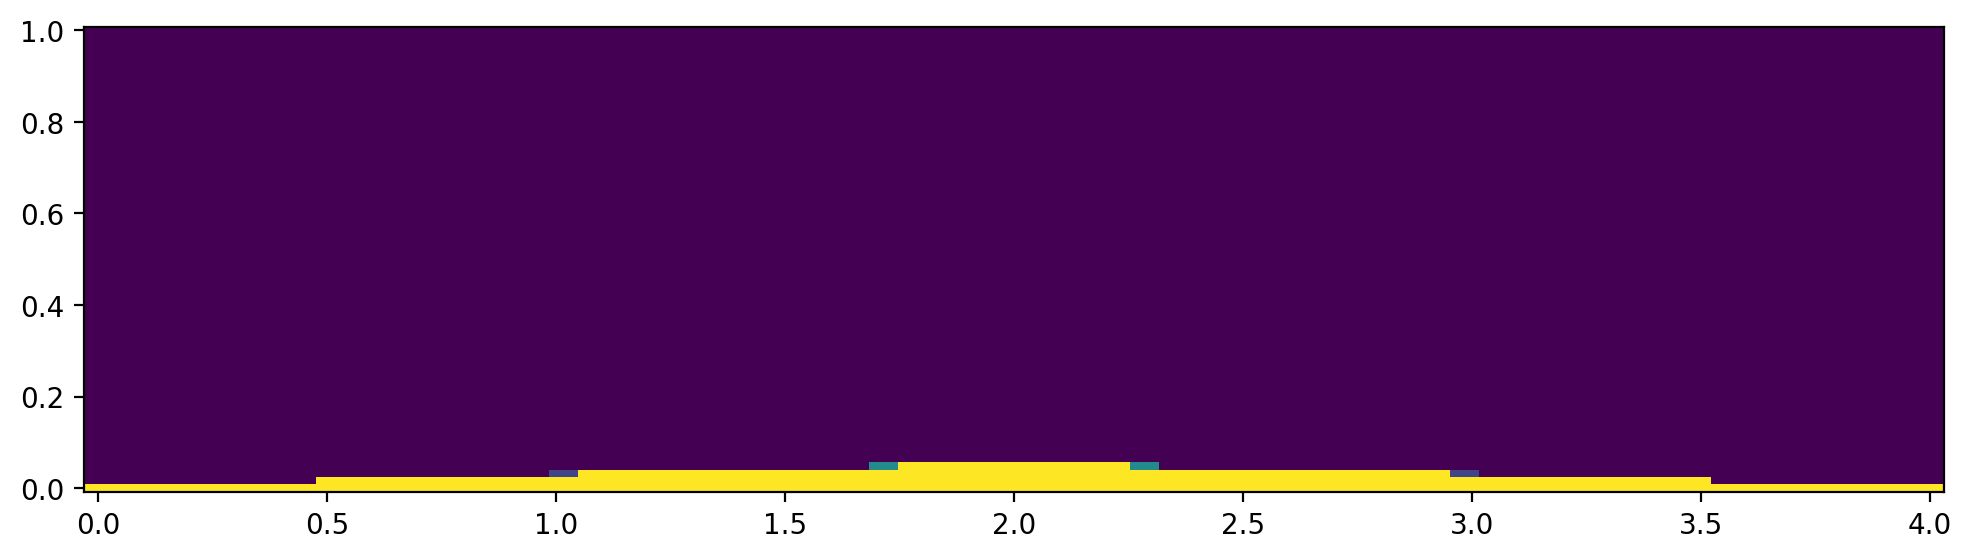

In [109]:
# Coarsen the shape, deliberately
# This lets us use a smooth interpolation to go back to large size but with smooth rather than sharp boundaries for the IBM
# note: this does not need to be a multiple of the original pixel size of the image
print(x.shape, y.shape)
x2 = np.linspace(np.min(x), np.max(x), num=64)
y2 = np.linspace(np.min(y), np.max(y), num=64)
X, Y = np.meshgrid(x2, y2)
Z = interp(x2, y2)

fig, ax = plt.subplots(figsize=[12,12])
ax.pcolormesh(X, Y, Z, shading='auto')
ax.set_aspect(1)

/state/partition1/job-48682867/ipykernel_1006746/4184127785.py:3: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interp_smooth = sci.interp2d(x2,y2,Z)
/state/partition1/job-48682867/ipykernel_1006746/4184127785.py:6: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

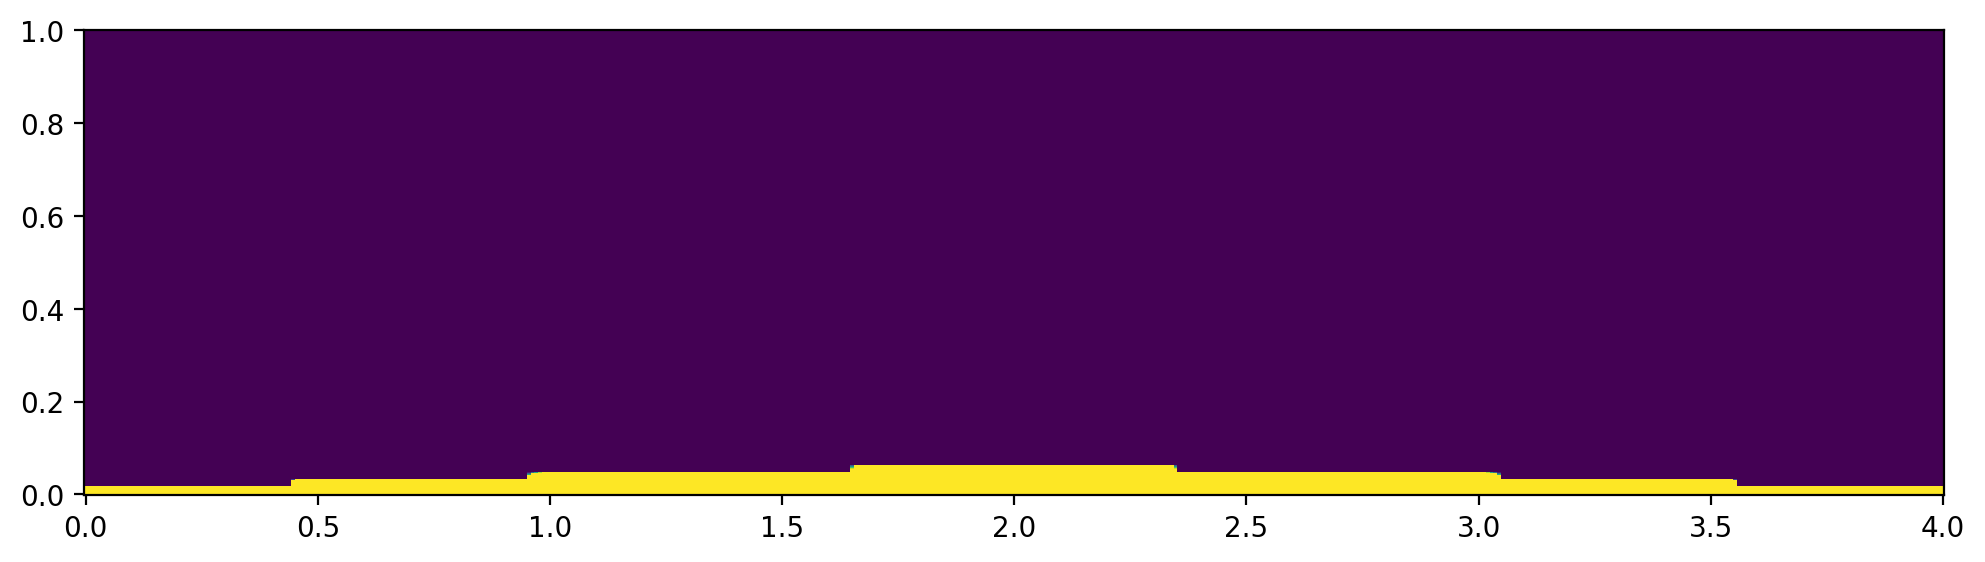

In [110]:
# interpolate the shape to smooth it; this makes a smooth transition at the edges of the IBM.
# note, this doesn't need to be a multiple of the coarsened grid, but I made it so here for convenience.
interp_smooth = sci.interp2d(x2,y2,Z)
x3 = np.linspace(np.min(x), np.max(x), num=512)
y3 = np.linspace(np.min(y), np.max(y), num=512)
z3 = interp_smooth(x3,y3)
fig, ax = plt.subplots(figsize=[12,12])
ax.pcolormesh(x3, y3, z3, shading='auto',vmax=1, vmin=0)
ax.set_aspect(1)

In [111]:
import numpy as np
import dedalus.public as d3
import dedalus.extras.plot_tools as dpt
from scipy.interpolate import RegularGridInterpolator
import logging
logger = logging.getLogger(__name__)
import copy
import h5py
import matplotlib
import re

# Parameters
Lx, Lz = 4,1
Nx, Nz = 512, 128
Ra_M = 1e5
D_0 = 0
D_H = 1/3
M_0 = 1
M_H = 0
N_s2=4/3
Qrad=0.0028

Prandtl = 1
dealias = 3/2
stop_sim_time = 600
timestepper = d3.RK222

dtype = np.float64

# %%
# Bases
coords = d3.CartesianCoordinates('x','z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
D = dist.Field(name='D', bases=(xbasis,zbasis))
M = dist.Field(name='M', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
Z = dist.Field(name='Z', bases=zbasis)
T = dist.Field(name='T', bases=(xbasis,zbasis))
C = dist.Field(name='C', bases=(xbasis,zbasis))


tau_p = dist.Field(name='tau_p')
tau_B1 = dist.Field(name='tau_B1', bases=xbasis)
tau_B2 = dist.Field(name='tau_B2', bases=xbasis)
tau_D1 = dist.Field(name='tau_D1', bases=xbasis)
tau_D2 = dist.Field(name='tau_D2', bases=xbasis)
tau_M1 = dist.Field(name='tau_M1', bases=xbasis)
tau_M2 = dist.Field(name='tau_M2', bases=xbasis)
tau_u1 = dist.VectorField(coords,name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords,name='tau_u2', bases=xbasis)
tau_u3 = dist.Field(name='tau_u3', bases=xbasis)
tau_u4 = dist.Field(name='tau_u4', bases=xbasis)
tau_T1 = dist.Field(name='tau_t1', bases=xbasis)
tau_T2 = dist.Field(name='tau_t2', bases=xbasis)
tau_C1 = dist.Field(name='tau_c1', bases=xbasis)
tau_C2 = dist.Field(name='tau_c2', bases=xbasis)


mask_grid = dist.Field(bases=(xbasis,zbasis))

mask_grid.change_scales(dealias)
xg = dist.local_grid(xbasis,scale=dealias)
print(xg.shape)
zg = dist.local_grid(zbasis,scale=dealias)
print(zg.shape)
# print(xg.squeeze(), zg.squeeze())
for i in range(xg.shape[0]):
    for j in range(zg.shape[1]):
        x = xg[i,0]
        z = zg[0,j]
        # print(x,z)
        #print(x,y) - need to rescale from [0,1] to [-1,1]
        mask_grid['g'][i,j] = interp_smooth(x, z)

(768, 1)
(1, 192)


/state/partition1/job-48682867/ipykernel_1006746/4245970855.py:77: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mask_grid['g'][i,j] = interp_smooth(x, z)
/state/partition1/job-48682867/ipykernel_1006746/4245970855.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.2

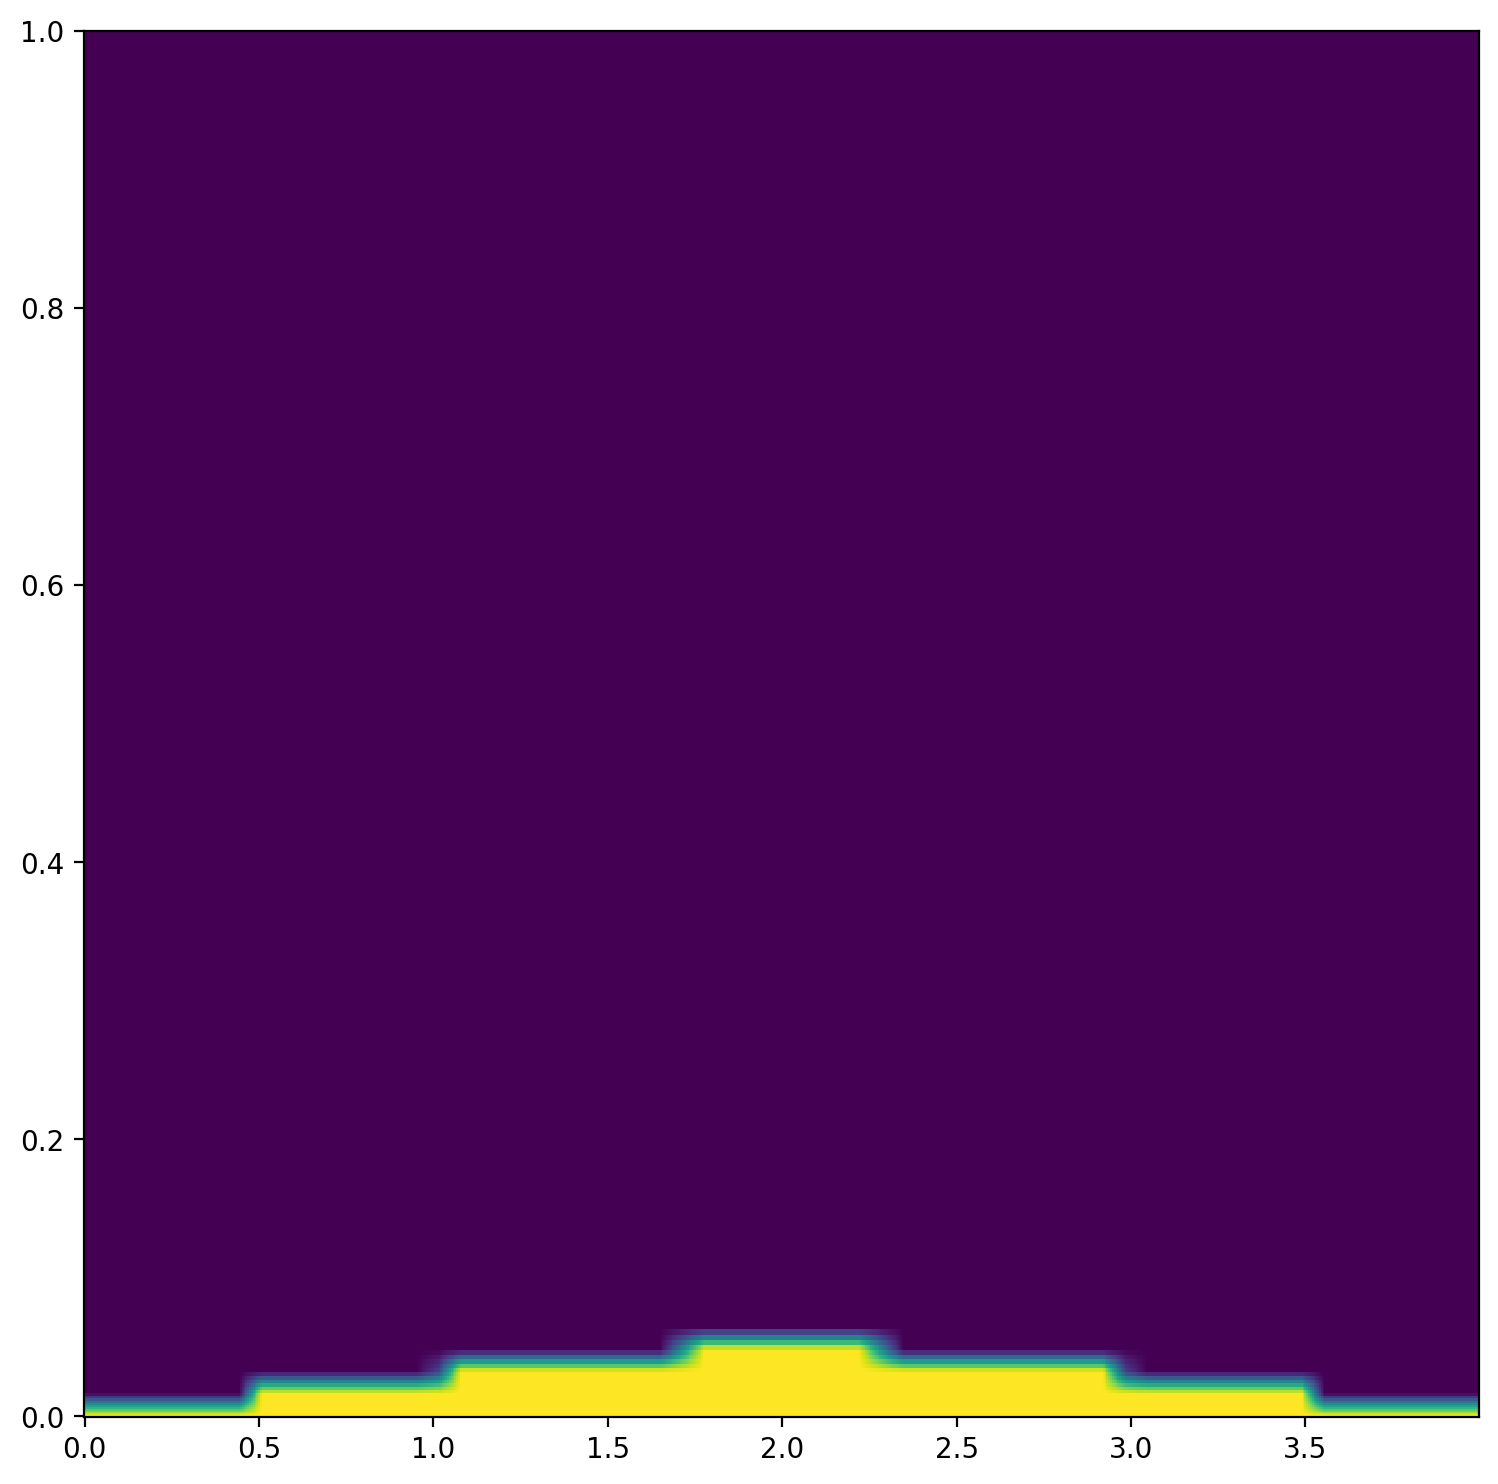

In [112]:

fig = plt.figure(figsize=[9,9])
ax = fig.add_subplot(1,1,1)

# xmesh, zmesh = np.meshgrid(xg, zg)
# xorder = np.argsort(xg)
# zorder = np.argsort(zg)
xmesh, zmesh = dpt.quad_mesh(xg[:,0], zg[0,:])
maskgraph=np.transpose(mask_grid['g'])
ax.pcolormesh(xmesh, zmesh, maskgraph,shading='auto')

In [113]:
import h5py
with h5py.File('mask.h5', 'w') as f:
    f['mask'] = mask_grid['g']
    f['x'] = x
    f['z'] = z

In [5]:
import numpy as np
import dedalus.public as d3
from scipy.interpolate import RegularGridInterpolator
import logging
logger = logging.getLogger(__name__)
import copy
import h5py
import matplotlib
import re

# Parameters
Lx, Lz = 4,1
Nx, Nz = 512, 128
Ra_M = -1e6
# D_0 = 0
# D_H = 1/3
M_0 = 0
M_H = 1/3
N_s2=4/3
Qrad=0.0028
gamma=100
gamma_s=1

Prandtl = 1
dealias = 3/2
stop_sim_time = 50
timestepper = d3.RK222
max_timestep = min(0.125, 0.25/gamma)
dtype = np.float64

# %%
# Bases
coords = d3.CartesianCoordinates('x','z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
D = dist.Field(name='D', bases=(xbasis,zbasis))
M = dist.Field(name='M', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
Z = dist.Field(name='Z', bases=zbasis)
T = dist.Field(name='T', bases=(xbasis,zbasis))
C = dist.Field(name='C', bases=(xbasis,zbasis))
time = dist.Field(name='time', bases=(xbasis,zbasis))
X = dist.Field(name='X', bases=xbasis)

tau_p = dist.Field(name='tau_p')
tau_B1 = dist.Field(name='tau_B1', bases=xbasis)
tau_B2 = dist.Field(name='tau_B2', bases=xbasis)
tau_D1 = dist.Field(name='tau_D1', bases=xbasis)
tau_D2 = dist.Field(name='tau_D2', bases=xbasis)
tau_M1 = dist.Field(name='tau_M1', bases=xbasis)
tau_M2 = dist.Field(name='tau_M2', bases=xbasis)
tau_u1 = dist.VectorField(coords,name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords,name='tau_u2', bases=xbasis)
tau_u3 = dist.Field(name='tau_u3', bases=xbasis)
tau_u4 = dist.Field(name='tau_u4', bases=xbasis)
tau_T1 = dist.Field(name='tau_t1', bases=xbasis)
tau_T2 = dist.Field(name='tau_t2', bases=xbasis)
tau_C1 = dist.Field(name='tau_c1', bases=xbasis)
tau_C2 = dist.Field(name='tau_c2', bases=xbasis)
tau_t1 = dist.Field(name='tau_t1', bases=xbasis)
tau_t2 = dist.Field(name='tau_t2', bases=xbasis)

# Substitutions    
#Kuo_Bretherton Equilibrium
kappa = (Ra_M * Prandtl/((M_0-M_H)*Lz**3))**(-1/2)
nu = (Ra_M / (Prandtl*(M_0-M_H)*Lz**3))**(-1/2)
print('kappa',kappa)
print('nu',nu)



x,z = dist.local_grids(xbasis,zbasis)

# Z.change_scales(3/2)
Z['g']=z
X['g']=x

ex,ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

B_op = (np.absolute(D - M - N_s2*Z)+ M + D - N_s2*Z)/2
lq = B_op/2 + np.absolute(B_op)

# F=(max((Lx/10-x)/(Lx/10),0)+max((-Lx+Lx/10+x)/(Lx/10),0))
F= (Lx/10-X)/(Lx/10)/2 +np.absolute((Lx/10-X)/(Lx/10))/2 + (-Lx+Lx/10+X)/(Lx/10)/2 + np.absolute((-Lx+Lx/10+X)/(Lx/10))/2

max = lambda A,B: (abs(A-N_s2*z-B)+A-N_s2*z+B)/2
eva = lambda A: A.evaluate()

dz= lambda A: d3.Differentiate(A, coords['z'])
dx= lambda A: d3.Differentiate(A, coords['x'])


ux=u@ex
uz=u@ez
dxux=dx(ux)
dzux=dz(ux)
dxuz=dx(uz)
dzuz=dz(uz)

grad_u = d3.grad(u) + ez* lift(tau_u1) # First-order reduction
grad_ux = grad_u@ex # First-order reduction
grad_uz = grad_u@ez # First-order reduction
grad_M = d3.grad(M) + ez*lift(tau_M1) # First-order reduction
grad_D = d3.grad(D) + ez*lift(tau_D1) # First-order reduction
grad_T = d3.grad(T) + ez*lift(tau_T1)
grad_C = d3.grad(C) + ez*lift(tau_C1)




mask = dist.Field(bases=(xbasis,zbasis))
sponge = dist.Field(bases=(xbasis,zbasis))
grid_slices = dist.layouts[-1].slices(mask.domain, dealias)
#Mountain
mask_file = 'masks/mask.h5'
with h5py.File(mask_file) as f:
    logger.info('loading mask from {}'.format(mask_file))
    mask.change_scales(dealias)
    mask['g'] = f['mask'][:,grid_slices[-1]]
mask = d3.Grid(mask).evaluate()
#Sponge 
mask_file = 'masks/mask_sp.h5'
with h5py.File(mask_file) as f:
    logger.info('loading mask from {}'.format(mask_file))
    sponge.change_scales(dealias)
    sponge['g'] = f['mask'][:,grid_slices[-1]]
    

sponge = d3.Grid(sponge).evaluate()




kappa 0.0005773502691896258
nu 0.0005773502691896258
2024-08-05 19:03:45,477 __main__ 0/1 INFO :: loading mask from masks/mask.h5
2024-08-05 19:03:45,503 __main__ 0/1 INFO :: loading mask from masks/mask_sp.h5


In [29]:

# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, M, u, time, tau_p, tau_M1, tau_M2, tau_u1, tau_u2], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p= 0")
problem.add_equation("dt(M) - kappa*div(grad_M) + lift(tau_M2) = - u@grad(M)  - mask*gamma*(M-M_0)  -F*sponge*gamma_s*(M-(Lz-Z)/Lz) ")
problem.add_equation("dt(u) - nu*div(grad_u) + grad(p)  + lift(tau_u2) -M*ez = - u@grad(u) - mask*gamma*u- F*sponge*gamma_s*(u-10/1*Z*ex)")
problem.add_equation("dt(time) = 1 ")
problem.add_equation("u(z=0) = 0")
problem.add_equation("uz(z=Lz) = 0")
problem.add_equation("dz(ux)(z=Lz)=0")
problem.add_equation("M(z=0) = M_0")
problem.add_equation("M(z=Lz) = M_H")
# problem.add_equation("dx(time)(z=0) = 0")
# problem.add_equation("dz(time)(z=0) = 0")
# problem.add_equation("dx(time)(z=Lz) = 0")
# problem.add_equation("dz(time)(z=Lz) = 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

{'LHS': Integrate(Integrate(<Field 22880119201872>)),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.float64,
 'M': 0,
 'L': Integrate(Integrate(<Field 22880119201872>)),
 'F': <Field 22880119208256>,
 'domain': <dedalus.core.domain.Domain at 0x14cf3160baf0>,
 'matrix_dependence': array([ True,  True]),
 'matrix_coupling': array([False,  True])}

In [ ]:
# %%
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time


# %%
# Initial condition
M.fill_random('g', seed=28, distribution='normal', scale=1e-3) # Random noise
M['g'] *= z * (Lz - z) # Damp noise at walls
M['g'] += (M_H-M_0)*z+M_0 # Add linear background
M.change_scales(dealias)

M['g'] *=(1-mask['g']) # Apply mask
M['g'] *= (1-sponge['g']) # Apply sponge
time['g']=0

# M.change_scales(1)
# Z.change_scales(1)


# %%
# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots',sim_dt=0.25, max_writes=1)
snapshots.add_tasks(solver.state,layout='g')
snapshots.add_task(u@u, layout='g', name='u square')

# %%
# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.1, min_change=0, max_dt=max_timestep)
CFL.add_velocity(u)

# %%
# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')


# %%
# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

In [73]:
import os
from os import listdir
import matplotlib.pyplot as plt
import re
    
folder_dir = "snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]

file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))

#read coordinates
with h5py.File('snapshots/snapshots_s1.h5', mode='r') as file:
    print(list(file.keys()))
    scalekeys=list(file['scales'].keys())
    taskkeys=list(file['tasks'].keys())
    print(scalekeys)
    print(list)
    print(taskkeys)
    #automatic read x y zhash: testing feature
    xhash=scalekeys[-2]
    zhash=scalekeys[-1]
    x=file['scales'][xhash]
    z=file['scales'][zhash]
    x=np.array(x)
    z=np.array(z)
    

n=0

for file in file_paths:
    with h5py.File(file, mode='r') as file:
        moistbuoyancy = file['tasks']['M']
        usq = file['tasks']['u square']
        # drybuoyancy = file['tasks']['D']
        # ql=np.maximum(moistbuoyancy[:]-drybuoyancy[:]+N_s2*z,0)
        st = file['scales/sim_time']
        for t in range(len(st)):
            m=np.transpose(moistbuoyancy[t,:,:])
            u=np.transpose(usq[t,:,:])
            plt.contourf(x, z, m, cmap='RdBu_r')
            plt.colorbar(label='M')
            # plt.colorbar(label='u square')
            plt.xlabel('x')
            plt.ylabel('z')
            n=n+1
            # Add time title
            title = "t="+str(st[t])
            plt.title(title)
            plt.savefig('plot'+'/M'+'_'+"%04d"%n+'.png', dpi=200,bbox_inches='tight')
            # plt.savefig('u'+'/u'+'_'+"%04d"%n+'.png', dpi=200,bbox_inches='tight')
            matplotlib.pyplot.close()

['scales', 'tasks']
['constant', 'iteration', 'sim_time', 'timestep', 'wall_time', 'write_number', 'x_hash_a17f3ecb40e2d97331db58aa9d1c625382f89a45', 'z_hash_d284f597a983ade9304b26b4bf92bfe0a3d1d846']
<class 'list'>
['M', 'p', 'tau_M1', 'tau_M2', 'tau_p', 'tau_u1', 'tau_u2', 'time', 'u', 'u square']


In [81]:

print(Z['g'])
print(Z['g'].shape)


[[1.67330413e-05 1.50590652e-04 4.18270036e-04 8.19699530e-04
  1.35477166e-03 2.02334318e-03 2.82523509e-03 3.76023270e-03
  4.82808570e-03 6.02850820e-03 7.36117881e-03 8.82574074e-03
  1.04218019e-02 1.21489350e-02 1.40066776e-02 1.59945324e-02
  1.81119671e-02 2.03584149e-02 2.27332744e-02 2.52359097e-02
  2.78656508e-02 3.06217938e-02 3.35036006e-02 3.65102998e-02
  3.96410864e-02 4.28951221e-02 4.62715360e-02 4.97694239e-02
  5.33878494e-02 5.71258438e-02 6.09824063e-02 6.49565044e-02
  6.90470742e-02 7.32530206e-02 7.75732174e-02 8.20065080e-02
  8.65517057e-02 9.12075934e-02 9.59729248e-02 1.00846424e-01
  1.05826786e-01 1.10912678e-01 1.16102738e-01 1.21395577e-01
  1.26789777e-01 1.32283894e-01 1.37876459e-01 1.43565972e-01
  1.49350911e-01 1.55229728e-01 1.61200848e-01 1.67262672e-01
  1.73413579e-01 1.79651920e-01 1.85976026e-01 1.92384205e-01
  1.98874739e-01 2.05445892e-01 2.12095904e-01 2.18822995e-01
  2.25625364e-01 2.32501190e-01 2.39448632e-01 2.46465829e-01
  2.5355

In [13]:

from lib.dedalus_Plot import Plot

Plotter=Plot(save_dir="/scratch/zb2113/DedalusData/mountain2")
Plotter.get_sim_time()
print(Plotter.sim_time)
Plotter.plot_all_snapshots('M', output_dir="/home/zb2113/Dedalus-Postanalysis/2D/mountain2" ,levelnum=30)

['scales', 'tasks']
Scale keys: ['constant', 'iteration', 'sim_time', 'timestep', 'wall_time', 'world_time', 'write_number', 'x_hash_a17f3ecb40e2d97331db58aa9d1c625382f89a45', 'z_hash_d284f597a983ade9304b26b4bf92bfe0a3d1d846']
Task keys: ['M', 'p', 'tau_M1', 'tau_M2', 'tau_p', 'tau_u1', 'tau_u2', 'time', 'u', 'u square', 'ux', 'uz']
[0.0, 0.25000000000000017, 0.5000000000000003, 0.752499999999995, 1.0018904284951429, 1.2510948440128542, 1.5014836396058195, 1.7516750742521434, 2.001598667077137, 2.251441846417726, 2.500162205993856, 2.7512732363502534, 3.0003186586637303, 3.250048793961346, 3.500999684565775, 3.75044553144174, 4.001134253045277, 4.250201330413569, 4.500385003002862, 4.750164891140875, 5.000943233631659, 5.250987625571958, 5.500027823167115, 5.750278634411322, 6.0001767525171745, 6.250074870623027, 6.500678663053268, 6.75056443868975, 7.000415865311594, 7.2503796874114315, 7.500227975217435, 7.750245972981617, 8.000121498564432, 8.250551445813986, 8.500342603469269, 8.75

In [12]:

from lib.dedalus_Plot import Plot

Plotter=Plot(save_dir="/scratch/zb2113/DedalusData/mountain")
Plotter.get_sim_time()
print(Plotter.sim_time)
Plotter.plot_all_snapshots('ux', output_dir="/home/zb2113/Dedalus-Postanalysis/2D/mountain" ,levelnum=10)

['scales', 'tasks']
Scale keys: ['constant', 'iteration', 'sim_time', 'timestep', 'wall_time', 'world_time', 'write_number', 'x_hash_a17f3ecb40e2d97331db58aa9d1c625382f89a45', 'z_hash_d284f597a983ade9304b26b4bf92bfe0a3d1d846']
Task keys: ['Fsponge', 'M', 'p', 'tau_M1', 'tau_M2', 'tau_p', 'tau_u1', 'tau_u2', 'time', 'u', 'u square', 'ux', 'uz']
[0.0, 0.25000000000000017, 0.5000000000000003, 0.752499999999995, 1.0018904284951429, 1.2510948440128542, 1.5014836396058195, 1.7516750742521434, 2.001598667077137, 2.251441846417726, 2.500162205993856, 2.7512732363502534, 3.0003186586637303, 3.2500487939613594, 3.5009996845658735, 3.750445531441922, 4.001134253045459, 4.250201330413751, 4.500385003003017, 4.750164891140932, 5.000943233631717, 5.250987625572016, 5.500027823167173, 5.75027863441138, 6.000176752517232, 6.250074870623084, 6.500678663054223, 6.750597565662063, 7.000556513759262, 7.250550697030017, 7.500176711474208, 7.750166129142792, 8.000370082322732, 8.250594798235905, 8.500230923

In [5]:

from lib.dedalus_Plot import Plot

Plotter=Plot(save_dir="/scratch/zb2113/DedalusData/mountain2")
Plotter.get_sim_time()
print(Plotter.sim_time)
Plotter.plot_all_snapshots('uz', output_dir="/home/zb2113/Dedalus-Postanalysis/2D/mountain2",figure_size=(5,8) ,levelnum=30)

['scales', 'tasks']
Scale keys: ['constant', 'iteration', 'sim_time', 'timestep', 'wall_time', 'world_time', 'write_number', 'x_hash_a17f3ecb40e2d97331db58aa9d1c625382f89a45', 'z_hash_d284f597a983ade9304b26b4bf92bfe0a3d1d846']
Task keys: ['M', 'p', 'tau_M1', 'tau_M2', 'tau_p', 'tau_u1', 'tau_u2', 'time', 'u', 'u square', 'ux', 'uz']
[0.0, 0.25000000000000017, 0.5000000000000003, 0.752499999999995, 1.0015779481682903, 1.2507120838686454, 1.5006907902033737, 1.7508040429016514, 2.0009468735409968, 2.250717356012572, 2.5004507457215155, 2.7514326550497117, 3.0005978990331563, 3.251222160099908, 3.5006499509920643, 3.750971332118726, 4.000118834913518, 4.250115729033365, 4.5011023938971935, 4.7508541849379355, 5.000627839843814, 5.250332749446925, 5.500037659050037, 5.750737408930451, 6.000575689261188, 6.250405480394186, 6.500671015996252, 6.750129684350947, 7.000597299651183, 7.250259552844344, 7.500700190876956, 7.75049341667634, 8.000033058588093, 8.250296039953811, 8.500144469050177, 

KeyboardInterrupt: 

In [ ]:

from lib.dedalus_Plot import Plot

Plotter=Plot(save_dir="/scratch/zb2113/DedalusData/mountain2")
Plotter.get_sim_time()
print(Plotter.sim_time)
Plotter.plot_all_snapshots('ux', output_dir="/home/zb2113/Dedalus-Postanalysis/2D/mountain2" ,figure_size=(6,12),levelnum=30)

In [ ]:

from lib.dedalus_Plot import Plot

Plotter=Plot(save_dir="/scratch/zb2113/DedalusData/mountain")
Plotter.get_sim_time()
print(Plotter.sim_time)
Plotter.plot_all_snapshots('uz', output_dir="/home/zb2113/Dedalus-Postanalysis/2D/mountain" ,levelnum=30)

0.9999693013931993


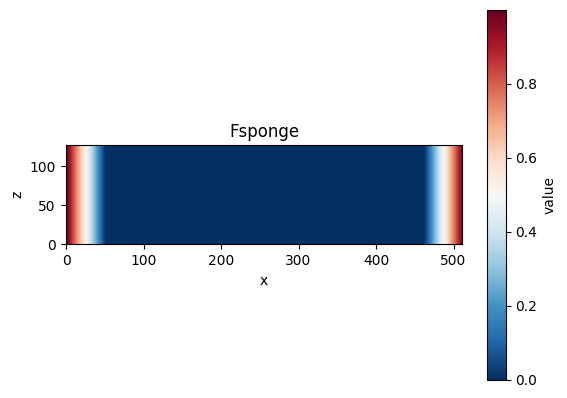

<Figure size 640x480 with 0 Axes>

In [8]:
import os
from os import listdir
import h5py
import re
import matplotlib
import matplotlib.pyplot as plt
from dedalus.extras import plot_tools
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

save_dir= "/scratch/zb2113/DedalusData/mountain2"
folder_dir = save_dir+"/maskcheck"

# X.change_scales(dealias)
# Z.change_scales(dealias)

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
#read the last file in the file path
file = file_paths[-1]
with h5py.File(file, mode='r') as file:
    M = np.transpose(file['tasks']['Fsponge'][-1,:,:])
    print(np.amax(M))
    plt.imshow(M, cmap='RdBu_r',origin='lower')
    plt.colorbar(label='value')
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Fsponge')

    plt.savefig('/home/zb2113/Dedalus-Postanalysis/2D/mountain/Fsponge.png', dpi=200, bbox_inches='tight')
    plt.show()
    plt.clf()

['scales', 'tasks']
Scale keys: ['constant', 'iteration', 'sim_time', 'timestep', 'wall_time', 'world_time', 'write_number', 'x_hash_44cb84ed962857f87e0a43f98b15e20aef99cae8', 'x_hash_a17f3ecb40e2d97331db58aa9d1c625382f89a45', 'z_hash_01a892095a215b941c579233acc92b7469101f11', 'z_hash_d284f597a983ade9304b26b4bf92bfe0a3d1d846']
Task keys: ['Fsponge', 'mask', 'sponge']
[0.0, 5.000938272916366, 10.000527963699035, 15.000280916553791, 20.00029710467769, 25.000315386491604, 30.000156163783846, 35.00039093104847, 40.000019800362864, 45.00038245736872]
0.0
0.9999999999999906


TypeError: Length of x (192) must match number of columns in z (768)

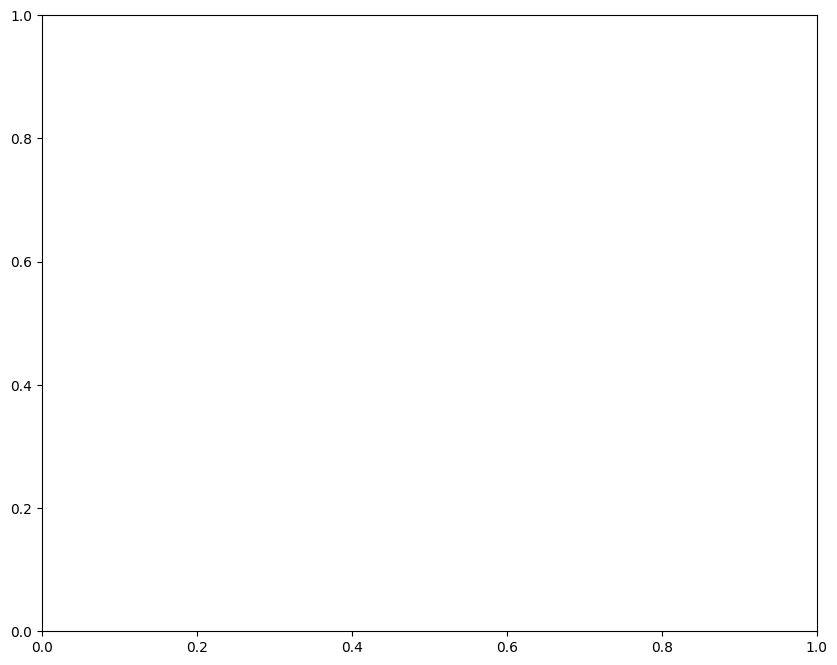

In [4]:
from lib.dedalus_Plot import Plot
maskcheck=Plot(save_dir="/scratch/zb2113/DedalusData/mountain2",handler='maskcheck')
maskcheck.get_sim_time()
print(maskcheck.sim_time)
maskcheck.plot_all_snapshots('sponge', output_dir="/home/zb2113/Dedalus-Postanalysis/2D/mountain2" ,levelnum=30)

In [1]:
from lib.dedalus_Plot import Plot

Plotter=Plot()
Plotter.animate('time',use_existing_pics=True)

ModuleNotFoundError: No module named 'moviepy'